# Can a fully dense STDP network achieve sparseness ?
it's a fully dense and i added a feedforward inhibition, as well as extra noise

Also using the 4 types of STDP

In [1]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import lmfit
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/.local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DictError in SLIInterpreter::execute: Key '/Install' does not exist in dictionary.
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [2]:
def fit_plot(popsize, spike_array, ax, datacol='.r', fitcol='--k', data_kws=None, do_title=True,
             seq_nbr=None):
    '''
    calculates a spike array gaussian lmfit profile and plots it
    '''
    # extracts the spiketrains

    # fit the gaussian
    x = np.linspace(0, popsize, popsize)
    y = spike_array

    mod = GaussianModel()
    pars = mod.guess(y, x=x)
    #pars['center'] = lmfit.Parameter('center', seq_nbr*15)
    out = mod.fit(y, pars, x=x)
    # print(out.fit_report(min_correl=0.25))

    # plot the fits
    out.plot_fit(ax=ax, datafmt=datacol, fitfmt=fitcol, data_kws=data_kws)

    # eye cancer-triggering lines
    sigma = out.best_values['sigma']

    if do_title:
        ax.set_title('Sequence #%s -- ' % seq_nbr + r'$\sigma$ = %.2f' % sigma)

    return ax, sigma


def tuning_function(i, j, B, N):  # von mises
    if B == np.inf:
        VM = np.ones_like(i*j)
    else:
        VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
    VM /= VM.sum(axis=0)
    return VM


def vary_angle(t):
    '''
    callback function that shifts the maximum angle
    '''

    simtime = 2000
    n_pop = 60
    shift = 40

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(
        angle, (t*shift)+(angle_input)/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    rates += 3
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    return t + simtime/4


def cut_spiketrain(array, window):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype=float)

        spiketrain_cut = np.where(
            (spiketrain_array > window*500) & (spiketrain_array < (window+1)*500))[0]

        spiketrain_len.append(len(spiketrain_cut))

    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

In [3]:
def SuperPlotter(SpikesP, SpikesE, SpikesI,
                 popsize, rates, simtime,
                 title='Title', markersize=.5,
                 figsize=(9, 6), shifts=None):
    # oh la jolie double fonction
    def plot_spiketrains(ax, spikes, color, ylabel, do_ticks):
        for spiketrain in spikes.spiketrains:
            y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
            ax.scatter(spiketrain, y, color=color, s=markersize)
            ax.set_ylabel(ylabel)
            if not do_ticks:
                ax.set_xticklabels([])
            if shifts != None:
                for i, times in enumerate(shifts):
                    ax.axvline(x=times, color='k',
                               linestyle='-.', linewidth=1)

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(3, 8)
    axs1 = plt.subplot(gs[0, :4])
    axs2 = plt.subplot(gs[1, :4])
    axs3 = plt.subplot(gs[2, :4])

    axs4 = plt.subplot(gs[0:1, 4:6])
    axs5 = plt.subplot(gs[0:1, 6:8])
    axs6 = plt.subplot(gs[1:2, 4:6])
    axs7 = plt.subplot(gs[1:2, 6:8])

    # what a fucking mess
    min_poisson = int(SpikesP.description.split('ID range')[
                      1].split('\n')[0].split(': ')[1].split('-')[0])
    max_poisson = int(SpikesP.description.split('ID range')[
                      1].split('\n')[0].split(': ')[1].split('-')[1])
    axs1.set_ylim(min_poisson, max_poisson)

    plot_spiketrains(axs1, SpikesP, color='g',
                     ylabel='Neuron Index', do_ticks=False)
    axs1.set_title('Poisson input')
    plot_spiketrains(axs2, SpikesI, color='b',
                     ylabel='Neuron Index', do_ticks=False)
    axs2.set_title('Inhibitory population')
    plot_spiketrains(axs3, SpikesE, color='r',
                     ylabel='Neuron Index', do_ticks=True)
    axs3.set_title('Excitatory population')
    axs3.set_xlabel('Time(ms)')

    axs4.plot(cut_spiketrain(SpikesP, 0), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 0), axs4, seq_nbr=1)[1]
    axs4.set_xticklabels([])
    axs4.set_yticklabels([])
    axs4.set_xlabel('')
    axs4.set_ylabel('')

    axs5.plot(cut_spiketrain(SpikesP, 1), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 1), axs5, seq_nbr=2)[1]
    axs5.set_xticklabels([])
    axs5.set_yticklabels([])
    axs5.set_xlabel('')
    axs5.set_ylabel('')

    axs6.plot(cut_spiketrain(SpikesP, 2), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 2), axs6, seq_nbr=3)[1]
    axs6.set_xticklabels([])
    axs6.set_yticklabels([])
    axs6.set_xlabel('')
    axs6.set_ylabel('')

    axs7.plot(cut_spiketrain(SpikesP, 3), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 3), axs7, seq_nbr=4)[1]
    axs7.set_xlabel('Neuron index')
    axs7.set_ylabel('Sequence spikes', rotation=270)
    axs7.yaxis.tick_right()
    axs7.yaxis.set_label_position("right")

    fig.suptitle(title, fontsize=12)
    plt.show()
    return fig

# Simulation

In [4]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 2000
rng = sim.NumpyRNG(seed=42)

rate_gain = 10.  # multiplier for the rates
angle_input = 30  # degrees
b_theta = 40  # degrees

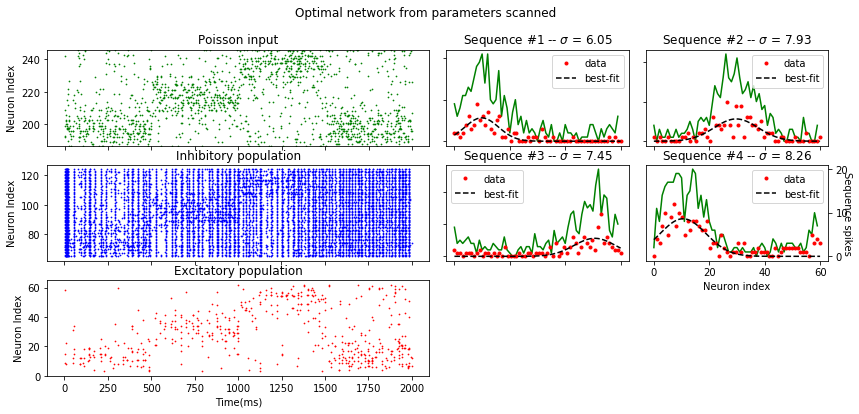

In [11]:
stdp_weight_init = .1
normal_weights = stdp_weight_init

delays = rnd('normal_clipped', mu=3, sigma=5, low=0.1,
             high=5,
             rng=rng)

# la stdp normale
causal_hebian_timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                                    A_plus=.025, A_minus=.025)
# la stdp à l'envers
anticausal_hebian_timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                                        A_plus=-.025, A_minus=-.025)
# la symétrique positive
causal_sym_timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                                 A_plus=.025, A_minus=-.025)
# la symétrique négative
anticausal_sym_timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                                     A_plus=-.025, A_minus=.025)


stdp_max_w = 2 * stdp_weight_init

sim.setup(timestep=.1, threads=4)
exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     label="Neurones Exictateurs")

inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     label="Neurones Inhibiteurs")

input_pop = sim.Population(n_pop,
                           sim.SpikeSourcePoisson(
                               rate=1500, duration=simtime, start=0),
                           label="Entree Orientation")
noise_pop = sim.Population(n_pop,
                           sim.SpikeSourcePoisson(
                               rate=5, duration=simtime, start=0),
                           label="Entree Orientation")

#INPUT STDP
in_mult = 5
in_causal_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=in_mult*stdp_max_w),
    weight=in_mult*stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)
in_anticausal_STDP_syn = sim.STDPMechanism(
    timing_dependence=anticausal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=in_mult*stdp_max_w),
    weight=in_mult*stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

#CAUSAL STDP
causal_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

#ANTICAUSAL STDP
anticausal_STDP_syn = sim.STDPMechanism(
    timing_dependence=anticausal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)
inh_anticausal_STDP_syn = sim.STDPMechanism(
    timing_dependence=anticausal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=-stdp_max_w),
    weight=-stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

#SYMETRIC POSITIVE STDP
sim_plus_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_sym_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)
inh_sim_plus_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_sym_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=-stdp_max_w),
    weight=-stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

#SYMETRIC NEGATIVE STDP
sim_neg_STDP_syn = sim.STDPMechanism(
    timing_dependence=anticausal_sym_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# Intras
syn_exc_exc = sim.Projection(exc, exc,
                             connector=sim.AllToAllConnector(
                                 allow_self_connections=False),
                             synapse_type=sim_plus_STDP_syn)
syn_inh_inh = sim.Projection(inh, inh,
                             connector=sim.AllToAllConnector(
                                 allow_self_connections=False),
                             synapse_type=sim_neg_STDP_syn)

# Inters
syn_exc_inh = sim.Projection(exc, inh,
                             connector=sim.AllToAllConnector(
                                 allow_self_connections=False),
                             synapse_type=anticausal_STDP_syn)
syn_inh_exc = sim.Projection(inh, exc,
                             connector=sim.AllToAllConnector(
                                 allow_self_connections=False),
                             synapse_type=inh_anticausal_STDP_syn)

# Input
syn_inp_exc = sim.Projection(input_pop, exc,
                             connector=sim.OneToOneConnector(),
                             synapse_type=in_causal_STDP_syn)
syn_inp_inh = sim.Projection(input_pop, inh,
                             connector=sim.OneToOneConnector(),
                             synapse_type=in_anticausal_STDP_syn)

'''# Noise
syn_noise_exc = sim.Projection(noise_pop, exc,
                             connector=sim.OneToOneConnector(),
                             synapse_type=sim.StaticSynapse(
                                 weight=1, delay=1))
syn_noise_inh = sim.Projection(noise_pop, inh,
                             connector=sim.OneToOneConnector(),
                             synapse_type=sim.StaticSynapse(
                                 weight=1, delay=1))'''

angle = 1. * np.arange(n_pop)
rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
rates /= rates.mean()
rates *= rate_gain
rates += 3
for i, cell in enumerate(input_pop):
    cell.set_parameters(rate=rates[i])

exc.record('spikes')
inh.record('spikes')
input_pop.record('spikes')
sim.run(simtime, callbacks=[vary_angle])
sim.end()

exc_data = exc.get_data().segments[0]
inh_data = inh.get_data().segments[0]
inp_data = input_pop.get_data().segments[0]

fig = SuperPlotter(inp_data, exc_data, inh_data,
                   60, rates, simtime,
                   title='Optimal network from parameters scanned',
                   figsize=(14, 6)
                   )
# fit_plot(n_pop, exc_data)

plt.show()
# fig.savefig('./figs/2018_12_11_Optim_ring_shifts.pdf', format = 'pdf', dpi = 200)

In [6]:
end_w = syn_exc_exc.get("weight", format="list", with_address=False)
delta_w = np.asarray(end_w) - stdp_weight_init

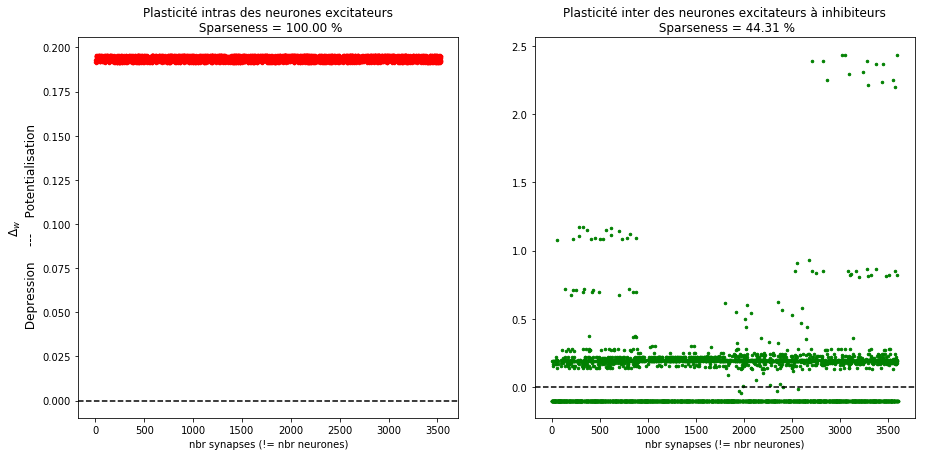

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

end_w = syn_exc_exc.get("weight", format="list", with_address=False)
delta_w = np.asarray(end_w) - stdp_weight_init

counts_null = 0
for weights in end_w:
    if weights == 0:
        counts_null += 1
sparseness = (1 - (counts_null/len(end_w))) * 100

axs[0].plot(delta_w, '.r', markersize=5)
axs[0].axhline(0, c='k', linestyle='--')
axs[0].set_xlabel('nbr synapses (!= nbr neurones)')
axs[0].set_ylabel(
    '$\Delta_w$\n Depression    ---    Potentialisation', fontsize=12)
axs[0].set_title(
    'Plasticité intras des neurones excitateurs\n Sparseness = %.2f %%' % sparseness)


end_w = syn_exc_inh.get("weight", format="list", with_address=False)
delta_w = np.asarray(end_w) - stdp_weight_init

counts_null = 0
for weights in end_w:
    if weights == 0:
        counts_null += 1
sparseness = (1 - (counts_null/len(end_w))) * 100

axs[1].plot(delta_w, '.g', markersize=5)
axs[1].axhline(0, c='k', linestyle='--')
plt.xlabel('nbr synapses (!= nbr neurones)')
plt.title('Plasticité inter des neurones excitateurs à inhibiteurs\n Sparseness = %.2f %%' % sparseness)
plt.show()
plt.pause(.1)

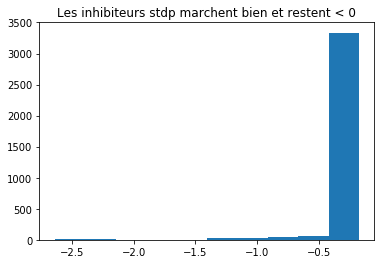

In [8]:
plt.hist(syn_inh_inh.get("weight", format="list", with_address=False))
plt.title('Les inhibiteurs stdp marchent bien et restent < 0')
plt.show()

In [9]:
plt.

SyntaxError: invalid syntax (<ipython-input-9-efb1a9b93a17>, line 1)